# Выбор локации для скважины
Заказчику нужно решить, где бурить новую скважину. Шаги для выбора локации обычно такие:
* В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
* Строят модель для предсказания объёма запасов в новых скважинах;
* Выбирают скважины с самыми высокими оценками значений;
* Определяют регион с максимальной суммарной прибылью отобранных скважин.
Заказчик предоставил пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль. 

Описание данных
Данные геологоразведки трёх регионов находятся в файлах: 
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

/tmp/ipykernel_403/1156748061.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Загрузка и предварительный просмотр данных

In [3]:
for i in range(3):
    pth = f'geo_data_{i}.csv'
    if os.path.exists(pth):
        if i == 0:
            df_geo_data_1 = pd.read_csv(pth)
        elif i == 1:
            df_geo_data_2 = pd.read_csv(pth)
        else:
            df_geo_data_3 = pd.read_csv(pth)
    elif os.path.exists(f'/datasets/{pth}'):
        if i == 0:
            df_geo_data_1 = pd.read_csv(f'/datasets/{pth}')
        elif i == 1:
            df_geo_data_2 = pd.read_csv(f'/datasets/{pth}')
        else:
            df_geo_data_3 = pd.read_csv(f'/datasets/{pth}')
    else:
        print(f'Something is wrong with {pth}')

In [4]:
def check_info(df):
    print('Общая информация:')
    df.info()
    print('\nОписание числовых столбцов:')
    display(df.describe())
    print('Первые строки таблицы')
    display(df.head(8))
    

In [5]:
check_info(df_geo_data_1)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Описание числовых столбцов:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Первые строки таблицы


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292


In [6]:
check_info(df_geo_data_2)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Описание числовых столбцов:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Первые строки таблицы


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522


In [7]:
check_info(df_geo_data_3)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Описание числовых столбцов:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Первые строки таблицы


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640


## Анализ данных
Рассмотрим распределения признаков по всем датасетам и сравним их

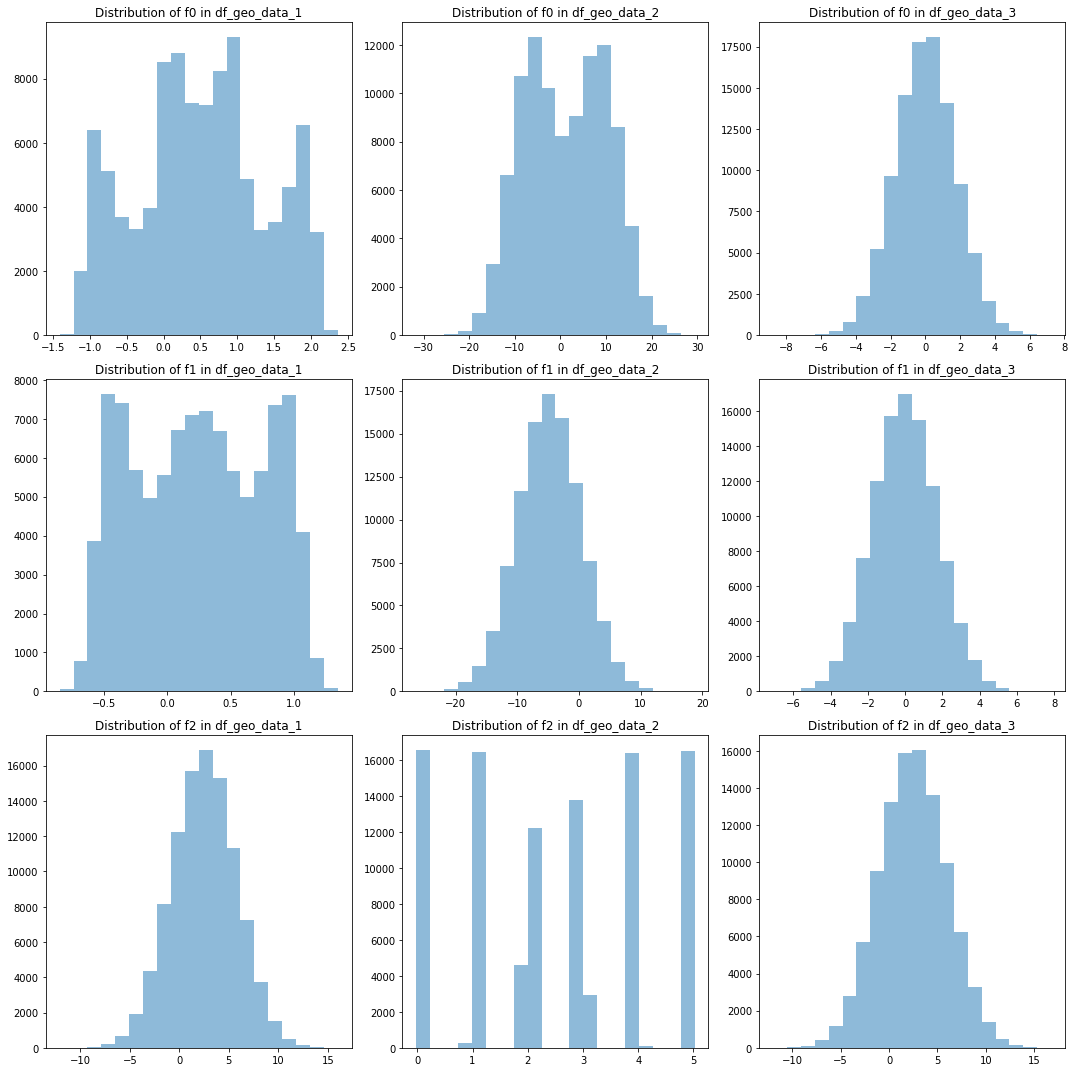

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
features = ['f0', 'f1', 'f2']

for i, feature in enumerate(features):
    axs[i, 0].hist(df_geo_data_1[feature], bins=20, alpha=0.5)
    axs[i, 0].set_title(f'Distribution of {feature} in df_geo_data_1')

    axs[i, 1].hist(df_geo_data_2[feature], bins=20, alpha=0.5)
    axs[i, 1].set_title(f'Distribution of {feature} in df_geo_data_2')

    axs[i, 2].hist(df_geo_data_3[feature], bins=20, alpha=0.5)
    axs[i, 2].set_title(f'Distribution of {feature} in df_geo_data_3')
    
plt.tight_layout()
plt.show()

Как можем заметить наиболее нормальное распределение у всех признаков в 3 регионе, при этом у f0 и f1 в первом регионе явная мультимодальность, а f2 во 2 регионе в отличие от всех остальных признаков - дискретный, что могло пройзойти из-за других методов измерений или неисправности прибора.

Проверим различны ли средние значения признаков по разным регионам

In [9]:
for i in range(3):
    stat, pvalue = ttest_ind(df_geo_data_1[f'f{i}'], df_geo_data_2[f'f{i}'])
    if pvalue < 0.05:
        print(f'Столбцы f{i} из df_geo_data_1 и f{i} из df_geo_data_2 имеют разные средние значения (p-value = {pvalue})')
    else:
        print(f'Столбцы f{i} из df_geo_data_1 и f{i} из df_geo_data_2 имеют похожие средние значения (p-value = {pvalue})')

    stat, pvalue = ttest_ind(df_geo_data_1[f'f{i}'], df_geo_data_3[f'f{i}'])
    if pvalue < 0.05:
        print(f'Столбцы f{i} из df_geo_data_1 и f{i} из df_geo_data_3 имеют разные средние значения (p-value = {pvalue})')
    else:
        print(f'Столбцы f{i} из df_geo_data_1 и f{i} из df_geo_data_3 имеют похожие средние значения (p-value = {pvalue})')

    stat, pvalue = ttest_ind(df_geo_data_2[f'f{i}'], df_geo_data_3[f'f{i}'])
    if pvalue < 0.05:
        print(f'Столбцы f{i} из df_geo_data_2 и f{i} из df_geo_data_3 имеют разные средние значения (p-value = {pvalue})')
    else:
        print(f'Столбцы f{i} из df_geo_data_2 и f{i} из df_geo_data_3 имеют похожие средние значения (p-value = {pvalue})')

Столбцы f0 из df_geo_data_1 и f0 из df_geo_data_2 имеют разные средние значения (p-value = 6.045086342822786e-112)
Столбцы f0 из df_geo_data_1 и f0 из df_geo_data_3 имеют разные средние значения (p-value = 0.0)
Столбцы f0 из df_geo_data_2 и f0 из df_geo_data_3 имеют разные средние значения (p-value = 0.0)
Столбцы f1 из df_geo_data_1 и f1 из df_geo_data_2 имеют разные средние значения (p-value = 0.0)
Столбцы f1 из df_geo_data_1 и f1 из df_geo_data_3 имеют разные средние значения (p-value = 0.0)
Столбцы f1 из df_geo_data_2 и f1 из df_geo_data_3 имеют разные средние значения (p-value = 0.0)
Столбцы f2 из df_geo_data_1 и f2 из df_geo_data_2 имеют похожие средние значения (p-value = 0.48465463748051196)
Столбцы f2 из df_geo_data_1 и f2 из df_geo_data_3 имеют похожие средние значения (p-value = 0.6170726507828368)
Столбцы f2 из df_geo_data_2 и f2 из df_geo_data_3 имеют похожие средние значения (p-value = 0.9617750891377419)


Как видим средние значения у f0 и f1 по всем регионам имеют статистически значимые различия

Посмотрим на корреляцию признаков

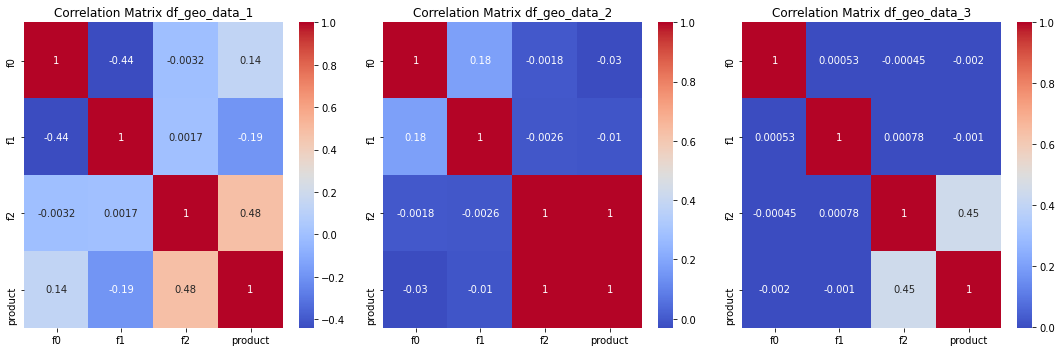

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, df in enumerate([df_geo_data_1, df_geo_data_2, df_geo_data_3]):
    corr = df.drop('id', axis=1).corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axs[i])
    axs[i].set_title(f'Correlation Matrix df_geo_data_{i+1}')

plt.tight_layout()
plt.show()

Во всех регионах признак f2 имеет значительную корреляцию с таргетом. 

## Предобработка данных
Проверим наличие пропусков и дубликатов по id, нам важно чтобы по каждой скважине у нас было лишь одно измерение

In [11]:
for i, df in enumerate([df_geo_data_1, df_geo_data_2, df_geo_data_3]):
    print(f"В датафрейме df_geo_data_{i+1}")
    print("Количество дубликатов по id =", df.duplicated(subset=['id']).sum())
    print("Количество пропусков", df.isna().sum(),"" ,sep='\n')

В датафрейме df_geo_data_1
Количество дубликатов по id = 10
Количество пропусков
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

В датафрейме df_geo_data_2
Количество дубликатов по id = 4
Количество пропусков
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

В датафрейме df_geo_data_3
Количество дубликатов по id = 4
Количество пропусков
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64



Удалим все дубликаты по id

In [12]:
for df in [df_geo_data_1, df_geo_data_2, df_geo_data_3]:
    df.drop_duplicates(subset=['id'], inplace=True)

Добавим индексацию по id

In [13]:
for df in [df_geo_data_1, df_geo_data_2, df_geo_data_3]:
    df.set_index('id', inplace=True)

## Построение моделей
Напишем функцию для моделирования

In [14]:
def modeling(df):
    y = df['product']
    X = df.drop('product', axis=1)
    final_p = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ])
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)
    final_p.fit(X_train, y_train)
    y_pred = final_p.predict(X_valid)
    print("Средний запас сырья на валидационной выборке =", y_pred.mean())
    print("RMSE =", mean_squared_error(y_valid, y_pred, squared=False))
    return final_p

Проведём моделирование и получим обученные модели

In [15]:
models = []
for i, df in enumerate([df_geo_data_1, df_geo_data_2, df_geo_data_3]):
    print(f"Для {i+1} месторождения")
    models.append(modeling(df))
    print() 

Для 1 месторождения
Средний запас сырья на валидационной выборке = 92.60984027552017
RMSE = 37.68508926201444

Для 2 месторождения
Средний запас сырья на валидационной выборке = 68.57703454115173
RMSE = 0.8928265978121422

Для 3 месторождения
Средний запас сырья на валидационной выборке = 94.93478722287514
RMSE = 40.080822438088305



Предсказанный средний запас во 2 регионе сильно ниже, чем в 1 и 3. Полученный RMSE является приемлемым лишь во втором регионе, в первом и третьем метрика слишком высока.

## Оценка скважин

Получим достаточный объём сырья для безубыточной разработки новой скважины

In [16]:
PRICE = 10 * 10 ** 9
AMOUNT = 200
UNIT_PRICE = 450000

In [17]:
print("Достаточный объём =", (PRICE / AMOUNT) / UNIT_PRICE)

Достаточный объём = 111.11111111111111


Как видим он больше чем средний объём по каждому из регионов, значит для получение прибыли мы не можем бурить каждую скважину.

Воспользуемся новой стратегией и будет выбирать для бурения 200 лучших по результатам моделирования скважин из 500 выбранных случайно. Для начала используем обученные ранее модели, для предсказания объёмов скважин.

In [18]:
for i, df in enumerate([df_geo_data_1, df_geo_data_2, df_geo_data_3]):
    df['product_pred'] = models[i].predict(df.drop('product', axis=1))

Теперь напишем функцию для расчёта доходов с 200 лучших скважин

In [19]:
def revenue(df):
    df = df.sort_values(by='product_pred', ascending=False).head(200)
    return (df['product'].sum()) * UNIT_PRICE

Напишем функцию использующую метод Bootstrap для оценки рисков

In [20]:
state = np.random.RandomState(12345)
def bootstrap_profit_distribution(df, num_samples=1000, sample_size=500):
    res = []
    for _ in range(num_samples):
        bootstrap_sample = df.sample(n=sample_size, replace=True, random_state=state)
        one_profit = revenue(bootstrap_sample) - 10 * 10 ** 9
        res.append(one_profit)
    return res

Получим с помощью этой функции выборки с возможной прибылью

In [21]:
profits = []
for df in [df_geo_data_1, df_geo_data_2, df_geo_data_3]:
    profits.append(bootstrap_profit_distribution(df))

Теперь же оценим риски такого подхода

Для 1 региона:
Средняя прибыль: 425245352.88274074
95%-й доверительный интервал: ['-39861674.756072894', '903856026.068038']
Риск убытков: 4.60%



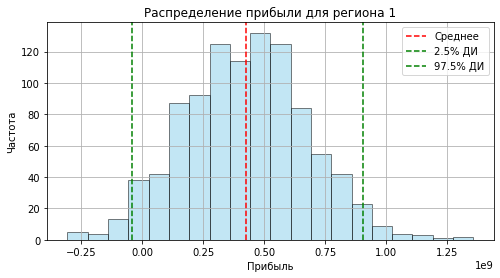

Для 2 региона:
Средняя прибыль: 444212271.7280935
95%-й доверительный интервал: ['40900405.407248504', '855721329.6600686']
Риск убытков: 1.70%



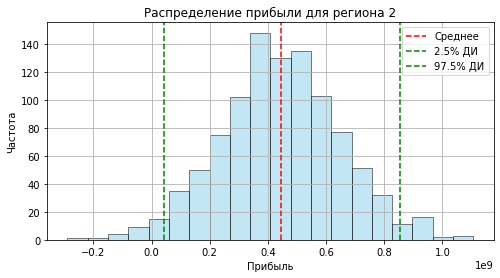

Для 3 региона:
Средняя прибыль: 369688980.73679125
95%-й доверительный интервал: ['-121370892.52356029', '880756617.1110203']
Риск убытков: 7.30%



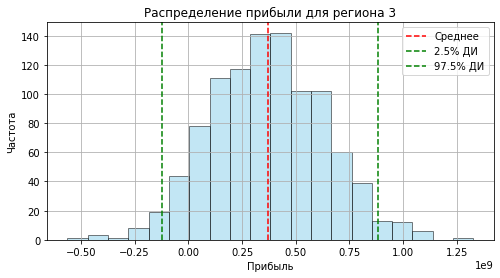

In [22]:
for i, profit in enumerate(profits):
    profit = np.array(profit) 
    mean_profit = np.mean(profit)
    confidence_interval = np.percentile(profit, [2.5, 97.5])
    loss_risk = (profit < 0).mean()
    
    print(f"Для {i+1} региона:")
    print("Средняя прибыль:", mean_profit)
    print("95%-й доверительный интервал:", [np.format_float_positional(x, trim='-') for x in confidence_interval])
    print(f"Риск убытков: {loss_risk:.2%}\n")
    
    plt.figure(figsize=(8, 4))
    plt.hist(profit, bins=20, alpha=0.5, color='skyblue', edgecolor='black')

    plt.axvline(mean_profit, color='red', linestyle='--', label='Среднее')
    plt.axvline(confidence_interval[0], color='green', linestyle='--', label='2.5% ДИ')
    plt.axvline(confidence_interval[1], color='green', linestyle='--', label='97.5% ДИ')
    
    plt.title(f"Распределение прибыли для региона {i+1}")
    plt.xlabel("Прибыль")
    plt.ylabel("Частота")
    plt.legend()
    plt.grid(True)
    plt.show()

Как видим первый и третий регионы нам не подходят из-за слишком высокого риска убытков.

## Общий вывод
В ходе данной работы мы провели исследовательский анализ, предобработку данных, моделирование и оценку возможной прибыли
* В ходе анализа данных мы выяснили, что у всех признаков в 3 регионе нормальное распределение, при этом у f0 и f1 в первом регионе явная мультимодальность, а f2 во 2 регионе в отличие от всех остальных признаков - дискретный, что могло произойти из-за других методов измерений или неисправности прибора. 
* Также мы проверили схожесть признаков по всем регионам и выяснили, что f0 и f1 по всем регионам имеют статистически значимые различия. При построении матрицы корреляции оказалось, что во всех регионах признак f2 имеет значительную линейную взаимосвязь с таргетом.
* В ходе предобработки данных мы лишь удалили дубликаты по id
* Для моделирования мы воспользовались линейной регрессией, при этом она показала хорошие результаты только во 2 регионе, в 1 и 3 исследуемая метрика RMSE оказалась достаточно большой.
* Оцененный достаточный объём сырья для безубыточной разработки новой скважины оказался выше, чем средний предсказанный объём сырья по всем 3 регионам.
*  Написав функцию для расчёта прибыли с одной скважины и воспользовавшись технологией Bootstrap мы выяснили, что достаточно низкий риск убытков лишь у скважин 2 региона.

В итоге мы можем посоветовать 2 регион для добычи, информация по которому содержится в файле "geo_data_1.csv", предсказанная в нём средняя прибыль - 444212271, при риске убытка 1.70%
